<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

import math

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

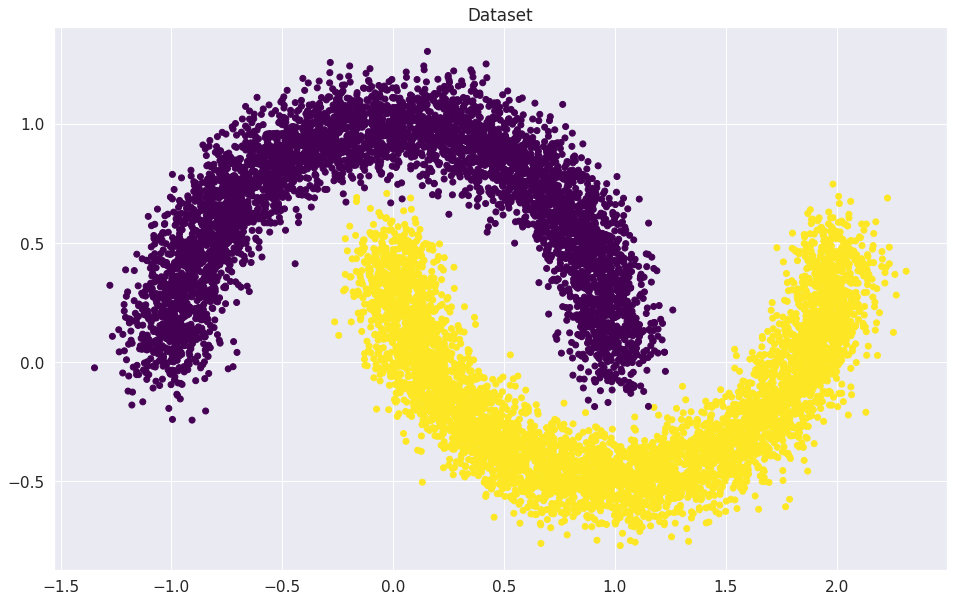

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.as_tensor(X_train, dtype=torch.float32)
y_train_t =  torch.as_tensor(y_train, dtype=torch.float32)
X_val_t =  torch.as_tensor(X_val, dtype=torch.float32)
y_val_t =  torch.as_tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [77]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weights = torch.nn.Parameter(torch.empty((self.out_features, self.in_features))) # почему вход и выход поменяны местами - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        if bias:
            self.bias_term = torch.nn.Parameter(torch.empty(self.out_features))
        else:
            pass
            nn.register_parameter('bias', None)
        self.reset_parameters() # инициализируем веса и сдвиги

    # Функция обновления параметров
    def reset_parameters(self) -> None:
      self.reset_weight()
      if self.bias is not None:
        self.reset_bias()

    # Функция обновления весов
    def reset_weight(self):
        with torch.no_grad():
          self.weights = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))

    # Функция обновления сдвигов, bias_distribution - каким распределением генерируем bias
    def reset_bias(self, bias_distribution='normal'):
      if bias_distribution=='normal': # нормальное распределение
        self.bias_term = nn.init.normal_(self.bias_term)
      if bias_distribution=='uniform': # но в оригинальной версии используется непрерывное равномерное распределение, тут подробнее: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        fan_in, fan_out = self._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0 # грацины распреления
        self.bias_term = nn.init.uniform_(self.bias_term, -bound, bound)

    # функция подсчета количества элементов на входе и выходе
    def _calculate_fan_in_and_fan_out(tensor):
      dimensions = tensor.dim()
      if dimensions < 2:
          raise ValueError("Тензор должен иметь как минимум два измерения!")
      if dimensions == 2:  # линейный случай
          fan_in = tensor.size(1)
          fan_out = tensor.size(0)
      else:
        # тут может быть обработка случая для случаев, когда размерность тензора > 2
        pass
      return fan_in, fan_out

    def forward(self, input): 
        logits = torch.matmul(input, torch.t(self.weights))
        if self.bias:
          logits +=  self.bias_term
        return logits

    def predict(self, X_features: torch.Tensor, threshold = 0.5):
      logits = self.forward(X_features)
      preds = torch.sigmoid(logits) > threshold
      preds.apply_(lambda x: 1 if x > threshold else 0)
      return preds

    def predict_proba(self, X_features: torch.Tensor):
      logits = self.forward(X_features)
      return torch.sigmoid(logits)

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
for name, param in linear_regression.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weights tensor([[-0.2990,  0.4849]])
bias_term tensor([1.0313])


In [ ]:
# Ответ: всего 3 обучаемых параметра: 2 параметра весов и 1 параметр смещения 

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(torch.flatten(outp), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.8671875
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** количество итераций очень сильно зависит от случайно сгенерированный в классе параметров, в моем случае - 755

### Визуализируем результаты

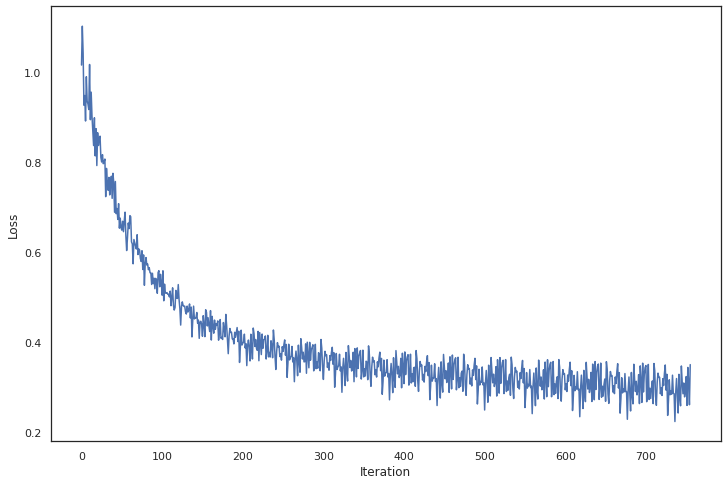

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

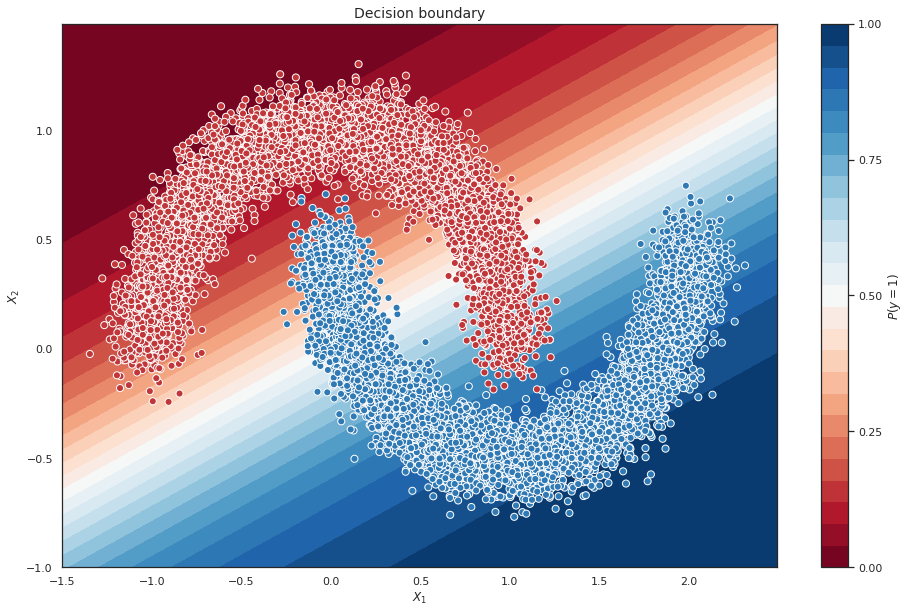

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # здесь я добавил методы predict и predict_proba в класс, чтобы не нарушать инкапсуляцию(ООП, все дела)
        preds = model.predict(x_batch)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

pred = predict(train_dataloader, linear_regression)
accuracy_score(pred, y_train_t)

0.8569333333333333

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8569333333333333

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [9]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

BATCH_SIZE = 128

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [10]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [11]:
activation = nn.ELU()

# сколько пискелей в картинке - от этого зависят размеры слоев сети
PICTURE_SIZE = np.prod(train_dataloader.dataset.train_data[0].shape)

# Входные и выходные размерности слоев
D_in = PICTURE_SIZE
L1_out, L2_out = [128] * 2
D_out = 10 

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D_in, L1_out),
    activation,
    nn.Linear(L1_out, L2_out),
    activation, 
    nn.Linear(L2_out, D_out)
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [15]:
MAX_EPOCHS = 10
accuracy = {"train": [], "valid": []}
for epoch in range(MAX_EPOCHS):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float32).sum()
            all =   y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)



Epoch: 1
Loader: train. Accuracy: 0.9423333333333334
Loader: valid. Accuracy: 0.9514333333333334


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
# Изменим прошлый функции, чтобы было удобней

In [16]:
from tqdm.notebook import trange, tqdm
def CheckAccuracy(model, criterion, optimizer, loaders, max_epochs = 1):
  accuracy = {"train": [], "valid": []}
  for epoch in trange(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                  # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
              else:
                  # Set model to ``eval`` mode and calculate outputs
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
              preds = outp.argmax(-1)
              correct = (preds.flatten() == y_batch).type(torch.float32).sum()
              all =   y_batch.size(0)
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  # Calculate gradients and make a step of your optimizer
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
            pass
          #     print(f"Epoch: {epoch+1}")
          # print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy

In [60]:
def set_activation(activation = 'elu'):
  if activation == 'plain':
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(D_in, L1_out),
      nn.Linear(L1_out, L2_out),
      nn.Linear(L2_out, D_out)) 
    return model
  elif activation == 'elu':
    activation = nn.ELU()
  elif activation == 'relu':
    activation = nn.ReLU()
  elif activation == 'leaky_relu':
    activation = nn.LeakyReLU()
  elif activation == 'sigmoid':
    activation = nn.Sigmoid()
  else:
    raise ValueError("Указана некорректная функция активации")
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(D_in, L1_out),
      activation,
      nn.Linear(L1_out, L2_out),
      activation,
      nn.Linear(L2_out, D_out)
  )
  return model

In [61]:
MAX_EPOCHS = 10
def test_activation_function(activation_name='elu'):
    model = set_activation(activation_name)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    return CheckAccuracy(model, criterion, optimizer, loaders, MAX_EPOCHS)


In [ ]:
plain_accuracy = test_activation_function('plain')
elu_accuracy = test_activation_function('elu')
relu_accuracy = test_activation_function('relu')
leaky_relu_accuracy = test_activation_function('leaky_relu')
sigmoid_accuracy = test_activation_function('sigmoid')

  0%|          | 0/10 [00:00<?, ?it/s]

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)>


  0%|          | 0/10 [00:00<?, ?it/s]

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)>


  0%|          | 0/10 [00:00<?, ?it/s]

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=128, out_features=10, bias=True)
)>


  0%|          | 0/10 [00:00<?, ?it/s]

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=128, out_features=10, bias=True)
)>


  0%|          | 0/10 [00:00<?, ?it/s]

In [62]:
# Функции для печати результатов
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def fprint(var):
  print(f' {namestr(var, globals())}:  {var}')

In [ ]:
fprint(plain_accuracy)
fprint(elu_accuracy)
fprint(relu_accuracy)
fprint(leaky_relu_accuracy)
fprint(sigmoid_accuracy)

 plain_accuracy:  {'train': [0.8644166666666667, 0.8951833333333333, 0.89995, 0.9023166666666667, 0.9041333333333333, 0.9052, 0.9068333333333334, 0.9080833333333334, 0.9093, 0.9101666666666667], 'valid': [0.8870833333333333, 0.9015166666666666, 0.9025, 0.9039666666666667, 0.90485, 0.9051833333333333, 0.906, 0.9069, 0.9079, 0.9084333333333333]}
 elu_accuracy:  {'train': [0.8808666666666667, 0.9433666666666667, 0.9607833333333333, 0.9694333333333334, 0.9749166666666667, 0.9794, 0.9821166666666666, 0.9847333333333333, 0.9853666666666666, 0.9868], 'valid': [0.9269, 0.95575, 0.9643666666666667, 0.9692, 0.9734, 0.9766833333333333, 0.9790166666666666, 0.9799, 0.9765833333333334, 0.9782]}
 relu_accuracy:  {'train': [0.8635833333333334, 0.93045, 0.9491333333333334, 0.9603333333333334, 0.9670666666666666, 0.97135, 0.9744333333333334, 0.9769833333333333, 0.9798833333333333, 0.98245], 'valid': [0.9182, 0.9449, 0.9584166666666667, 0.9656, 0.9688333333333333, 0.9683833333333334, 0.9718166666666667, 

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

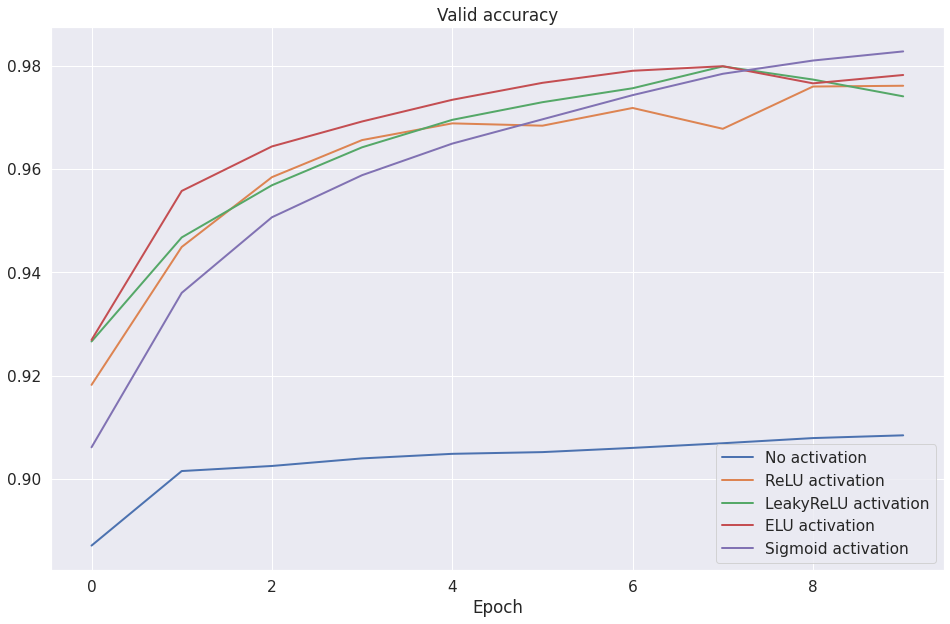

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(MAX_EPOCHS), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), sigmoid_accuracy['valid'], label="Sigmoid activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**  Сигмоида, accuracy 0.9827

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [18]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-30 08:32:18--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-30 08:32:19--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   160KB/s    in 0.3s    

2022-10-30 08:32:20 (160 KB/s) - ‘sample_photo.jpg’ saved [49337/4

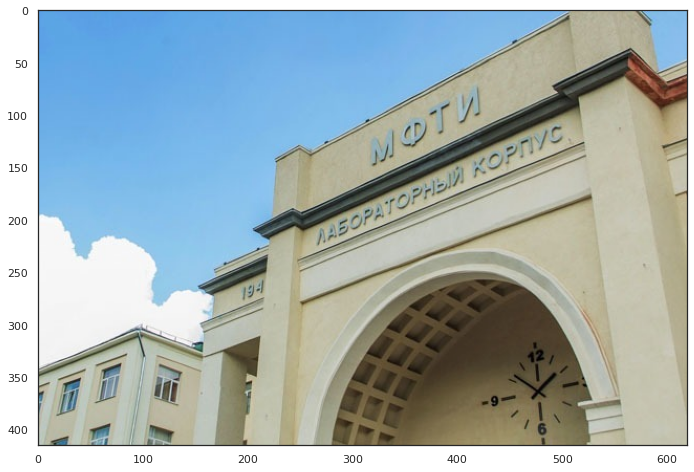

In [19]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [36]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)

kernels_list = [
    [
      [0, 0, 0],
      [0, 1, 0],
      [0, 0, 0] 
    ],
    [
      [0, 1, 0],
      [0, -2, 0],
      [0, 1, 0]
    ],
    [
      [0, 0, 0],
      [1, -2, 1],
      [0, 0, 0]
    ],
    [
      [0, 1, 0],
      [1, -4, 1],
      [0, 1, 0]
    ],
    [
      [0, -1, 0],
      [-1, 5, -1],
      [0, -1, 0]
    ],
    [
      [0.0625, 0.125, 0.0625],
      [0.125, 0.25, 0.125],
      [0.0625, 0.125, 0.0625]
    ]
]

  

In [41]:
def apply_kernel(RGB_img, kernel_unit):
  img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
  kernel = torch.tensor(kernel_unit).reshape(1, 1, 3, 3).type(torch.float32)

  kernel = kernel.repeat(3, 3, 1, 1)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  result = F.conv2d(img_t, kernel)[0]  #
  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3

  plt.imshow(result_np)
  plt.show()
  return

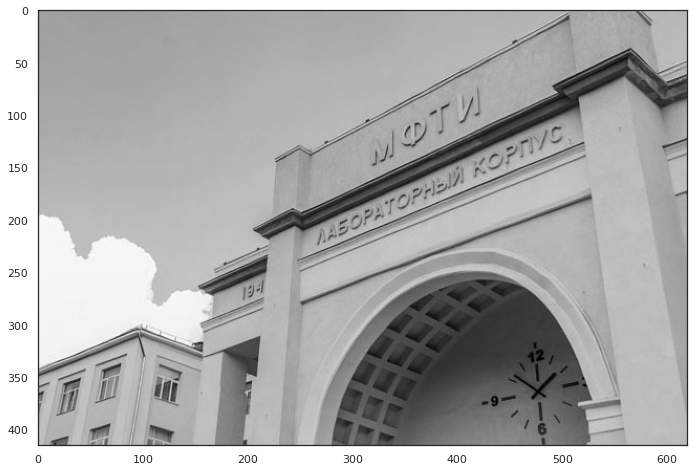

In [42]:
# 1. тождетсвенное преобразование
apply_kernel(RGB_img, [
      [0, 0, 0],
      [0, 1, 0],
      [0, 0, 0] 
    ])

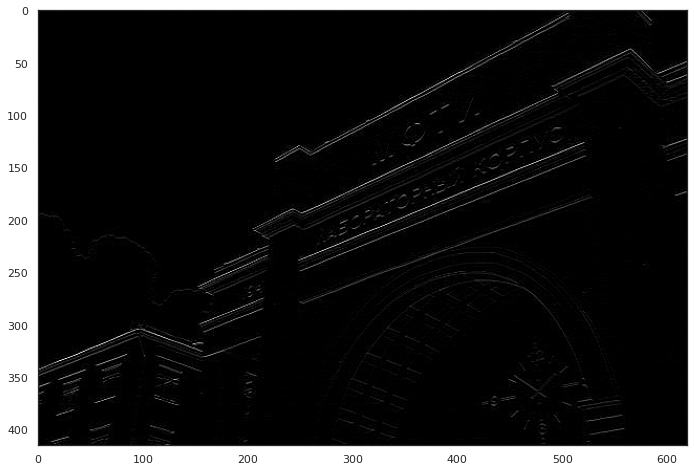

In [43]:
# 2. выделение горизонтальных границ
apply_kernel(RGB_img, [
      [0, 1, 0],
      [0, -2, 0],
      [0, 1, 0]
    ])

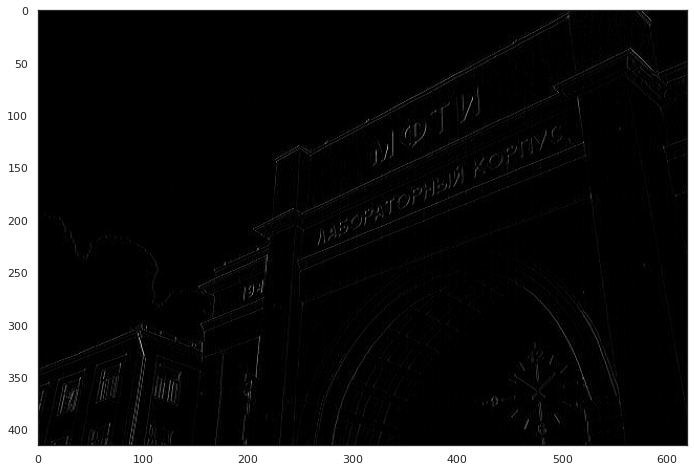

In [45]:
# 3. выделение вертикальных границ
apply_kernel(RGB_img, [
      [0, 0, 0],
      [1, -2, 1],
      [0, 0, 0]
    ])

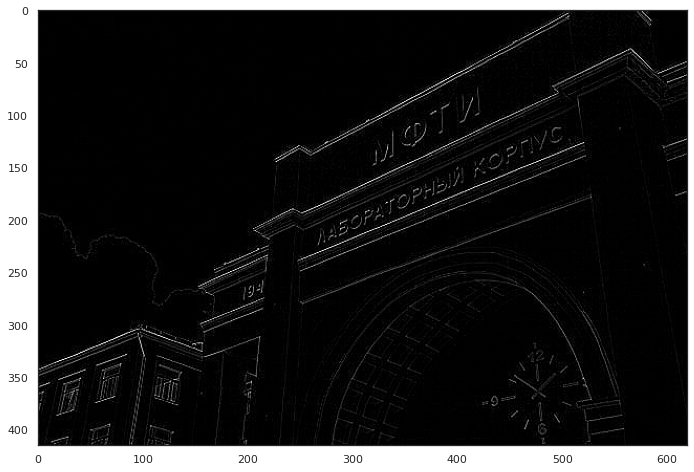

In [46]:
# 4. выделение границ
apply_kernel(RGB_img, [
      [0, 1, 0],
      [1, -4, 1],
      [0, 1, 0]
    ])

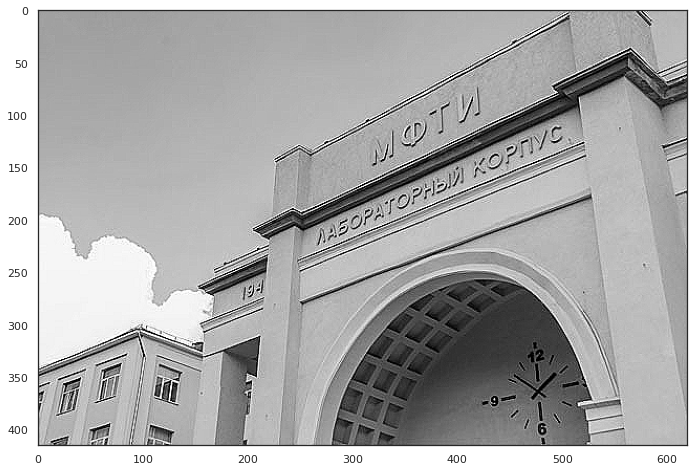

In [47]:
# 5. увеличение резкости
apply_kernel(RGB_img, [
      [0, -1, 0],
      [-1, 5, -1],
      [0, -1, 0]
    ])

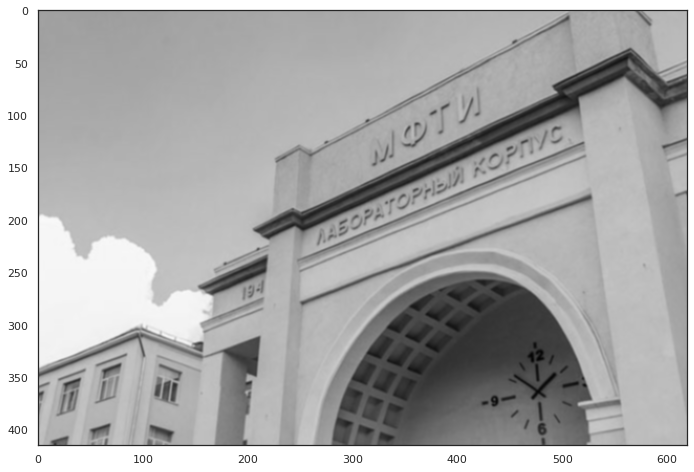

In [48]:
# 6. размытие
apply_kernel(RGB_img, [
      [0.0625, 0.125, 0.0625],
      [0.125, 0.25, 0.125],
      [0.0625, 0.125, 0.0625]
    ])

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие: **6**

2) Увеличение резкости: **5**

3) Тождественное преобразование: **1**

4) Выделение вертикальных границ: **3**

5) Выделение горизонтальных границ: **2**

6) Выделение границ: **4**

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [53]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.activ1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.activ2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activ2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x) 
        return x

In [54]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [56]:
MAX_EPOCHS = 10
accuracy = {"train": [], "valid": []}
for epoch in range(MAX_EPOCHS):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float32).sum()
            all =   y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9699
Loader: valid. Accuracy: 0.9727666666666667
Epoch: 2
Loader: train. Accuracy: 0.9771666666666666
Loader: valid. Accuracy: 0.9773833333333334
Epoch: 3
Loader: train. Accuracy: 0.9815166666666667
Loader: valid. Accuracy: 0.9808166666666667
Epoch: 4
Loader: train. Accuracy: 0.984
Loader: valid. Accuracy: 0.9836333333333334
Epoch: 5
Loader: train. Accuracy: 0.9857833333333333
Loader: valid. Accuracy: 0.9856333333333334
Epoch: 6
Loader: train. Accuracy: 0.98695
Loader: valid. Accuracy: 0.9868333333333333
Epoch: 7
Loader: train. Accuracy: 0.9878333333333333
Loader: valid. Accuracy: 0.9872833333333333
Epoch: 8
Loader: train. Accuracy: 0.9890833333333333
Loader: valid. Accuracy: 0.9880333333333333
Epoch: 9
Loader: train. Accuracy: 0.9894666666666667
Loader: valid. Accuracy: 0.9884666666666667
Epoch: 10
Loader: train. Accuracy: 0.9905333333333334
Loader: valid. Accuracy: 0.98795


In [71]:
lenet_accuracy = accuracy

Сравним с предыдущем пунктом

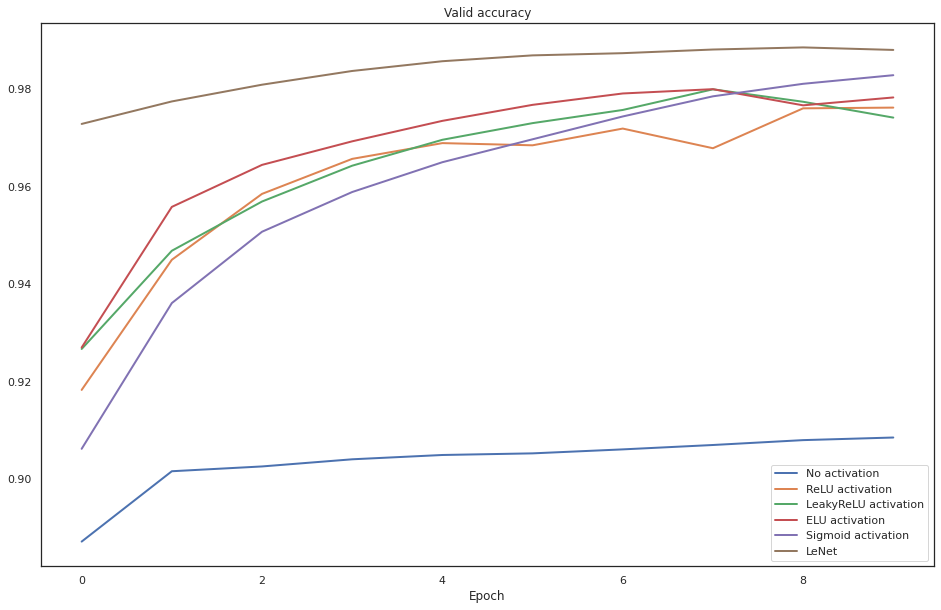

In [72]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(MAX_EPOCHS), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), sigmoid_accuracy['valid'], label="Sigmoid activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), lenet_accuracy['valid'], label="LeNet", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

In [76]:
np.mean(lenet_accuracy['valid'])
# Вывод: у LeNet accuracy выше!

0.9838800000000001

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98